In [5]:
from openff.toolkit import Molecule, Topology
import pandas as pd
import subprocess
import os
from rdkit import Chem
from rdkit.Chem import Draw 
import matplotlib.pyplot as plt
import hashlib
import py3Dmol
import shutil

In [2]:
!obabel -h

No input file or format spec or possibly a misplaced option.
Most options must come after the input files. (-i -o -O -m can be anywhwere.)

Open Babel 3.1.1 -- Feb 15 2024 -- 14:35:24
Usage:
obabel [-i<input-type>] <infilename> [-o<output-type>] -O<outfilename> [Options]
Try  -H option for more information.


In [3]:
smiles_csv = 'data/smiles.csv'
seq_csv = 'data/sequences.csv'
res_csv = 'data/residues.csv'
capped_smiles_csv = 'data/capped_smiles.csv'


df_capped_smiles = pd.read_csv(capped_smiles_csv) #solution NMR peptoid + capped SMILES string 
df_res = pd.read_csv(res_csv) #all the residues name + SMILES
df_seq = pd.read_csv(seq_csv) #solution NMR peptoid + residues name 

print(df_res)

                          SMILES                 full_nomenclature  \
0   *N([C@@H](C)C1CCCCC1)CC(=O)*  (S)-N-(1-cyclohexylethyl)glycine   
1    *N([C@H](C)C1CCCCC1)CC(=O)*  (R)-N-(1-cyclohexylethyl)glycine   
2         *N([C@@H](C)CC)CC(=O)*            (S)-N-(2-butyl)glycine   
3          *N([C@H](C)CC)CC(=O)*            (R)-N-(2-butyl)glycine   
4   *N([C@@H](C)c1ccccc1)CC(=O)*      (S)-N-(1-phenylethyl)glycine   
..                           ...                               ...   
61          *N(CC1CCCCC1)CC(=O)*       N-(cyclohexyl)methylglycine   
62              *N(CCCCC)CC(=O)*                   N-pentylglycine   
63             *N(CCCCCC)CC(=O)*                    N-hexylglycine   
64                     *NCC(=O)*                           Glycine   
65                    *NCCC(=O)*                      beta-Alanine   

   monomer_structure                                           peptoids  \
0                NaN           {'03AA1-5-A': '/api/peptoids/03AA1-5-A'}   
1        

## Visualize the Capped Residues Structure using RDKITs

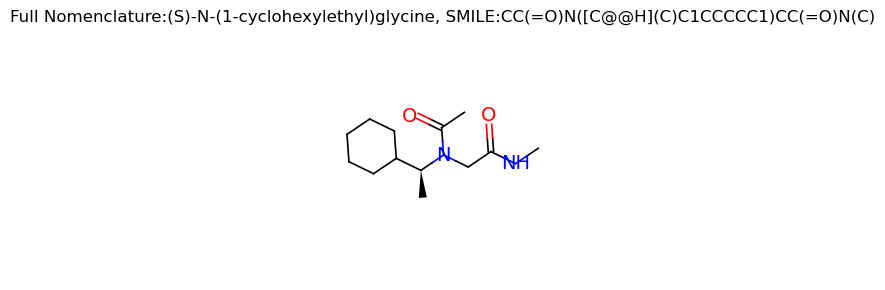

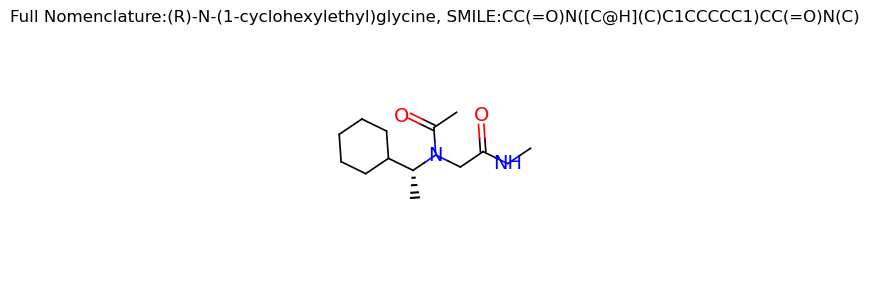

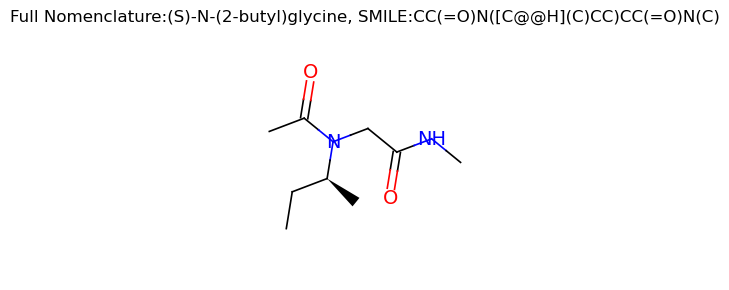

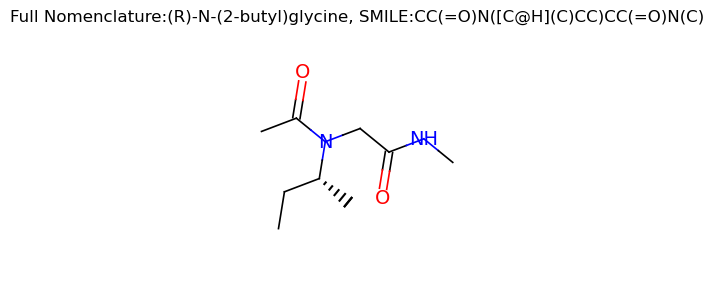

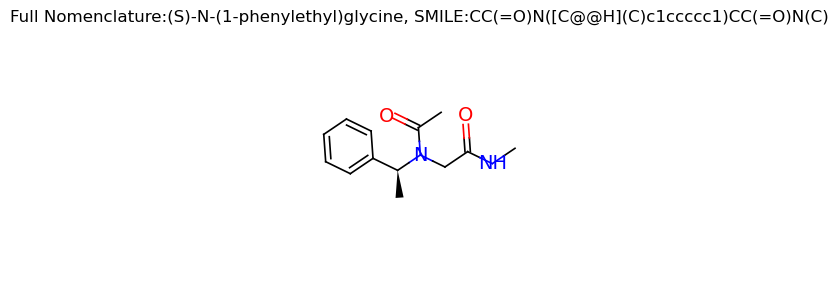

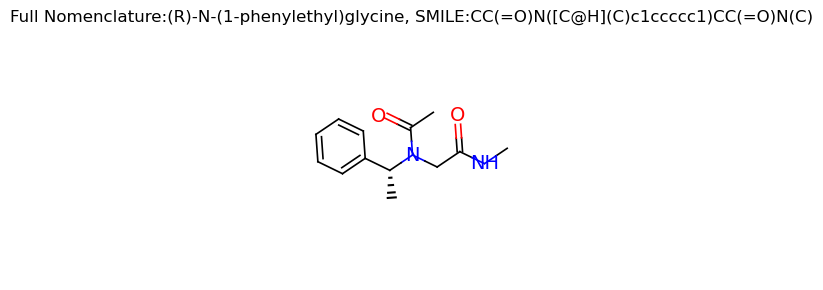

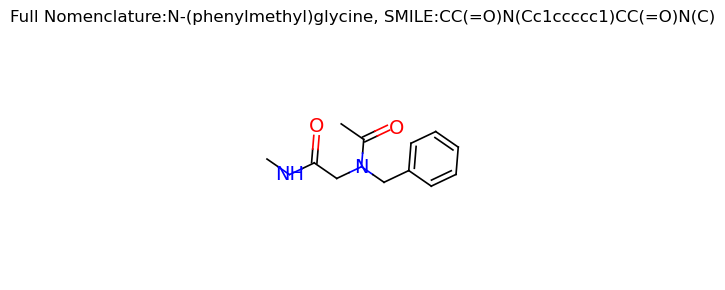

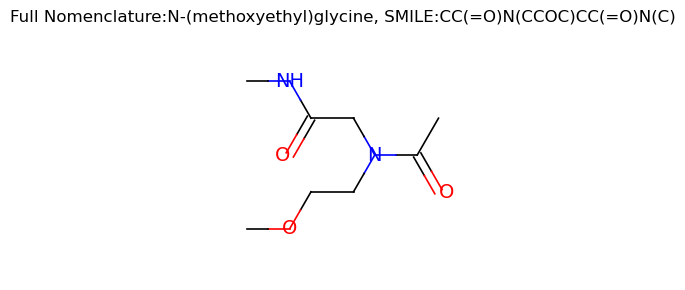

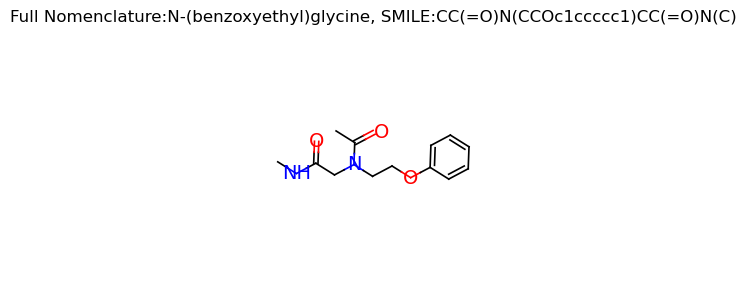

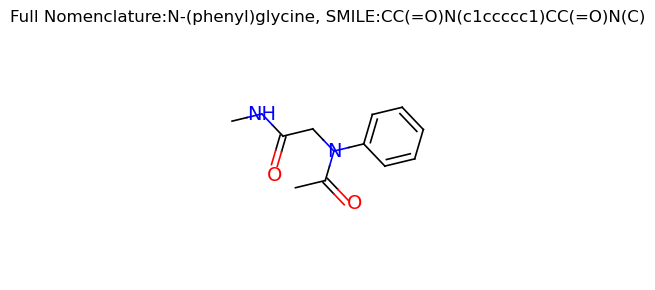

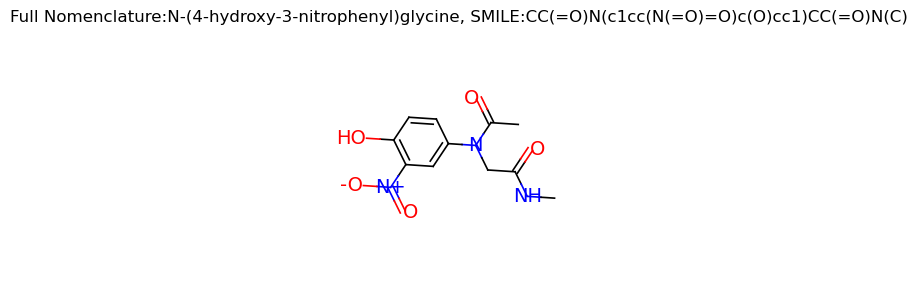

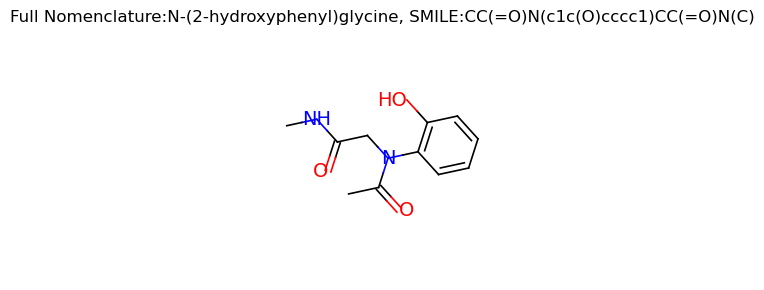

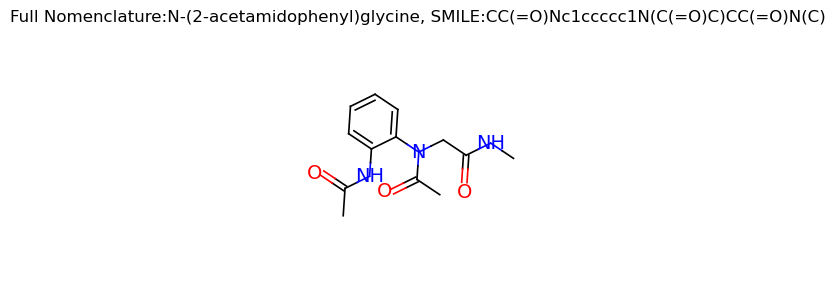

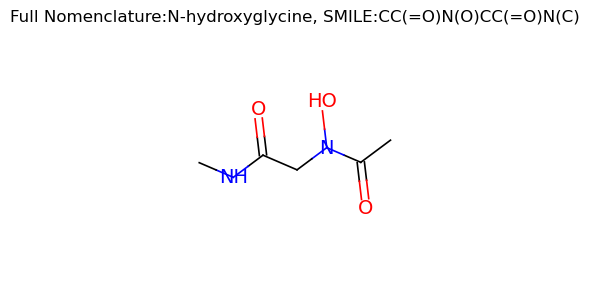

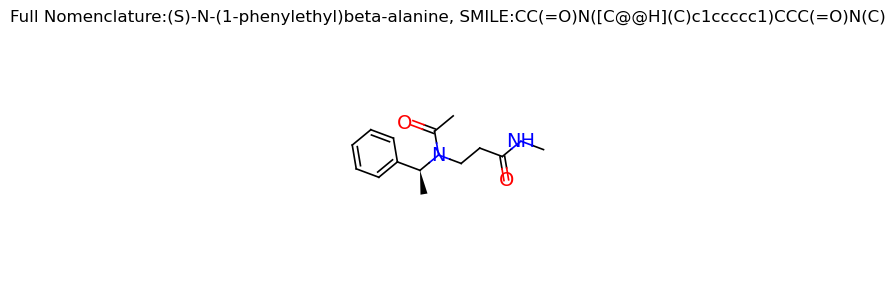

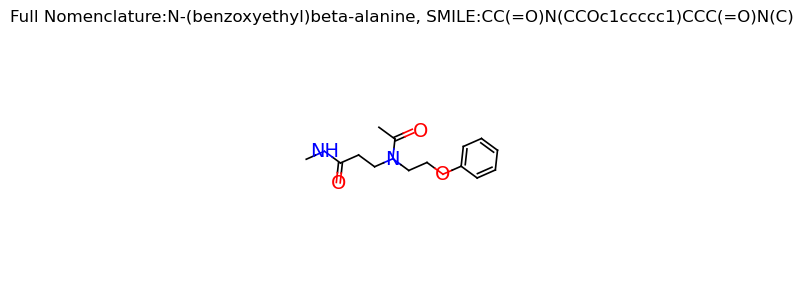

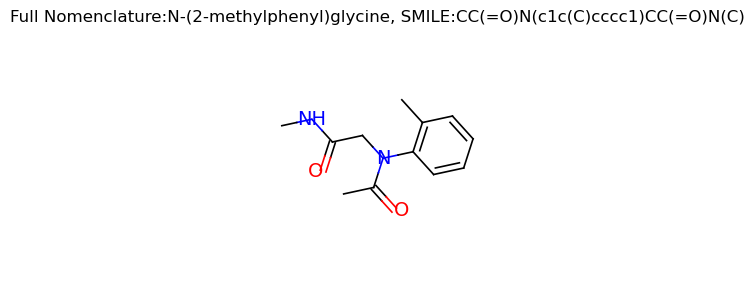

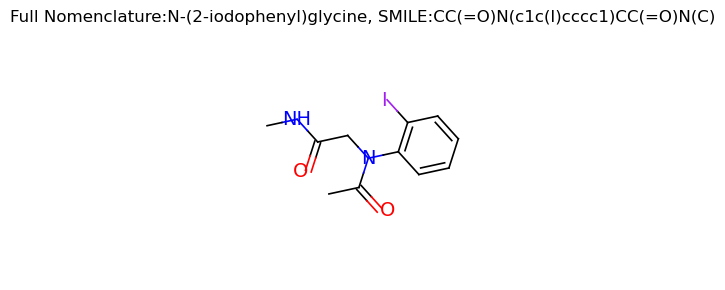

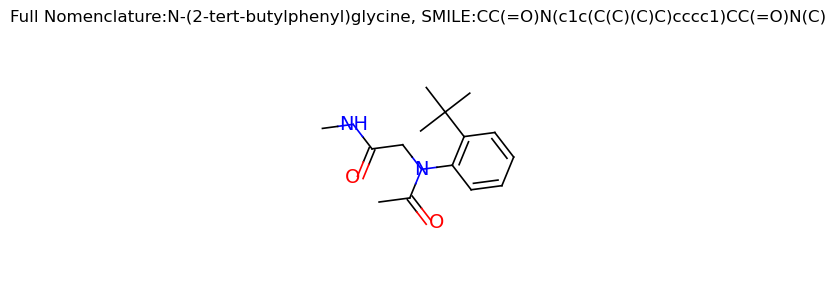

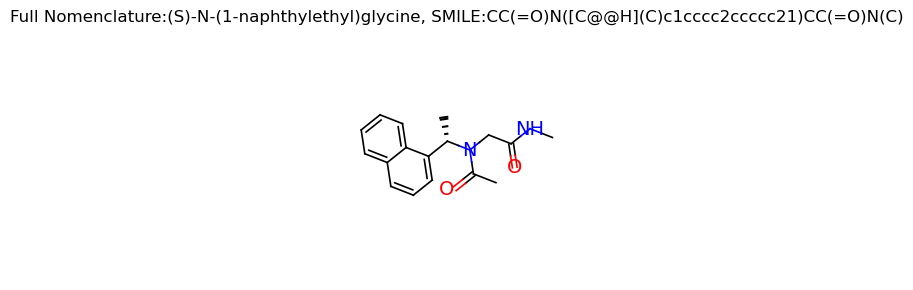

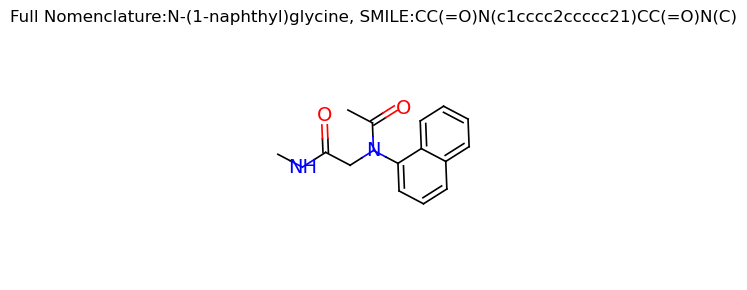

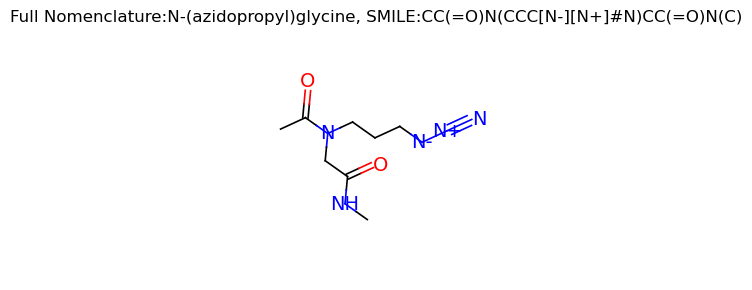

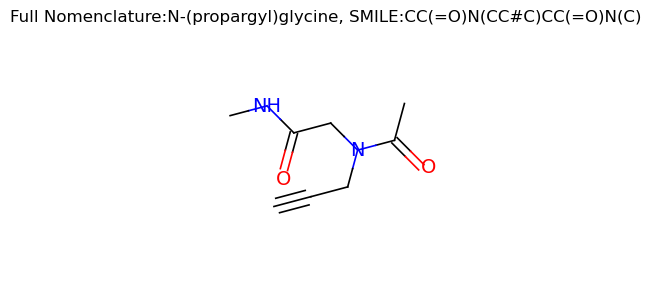

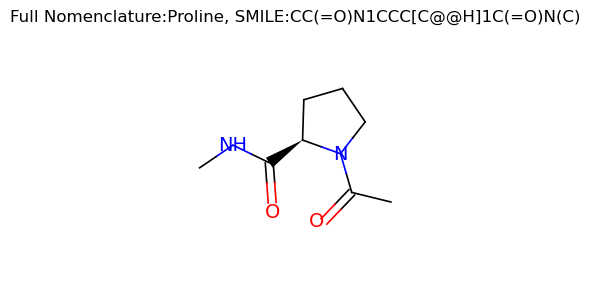

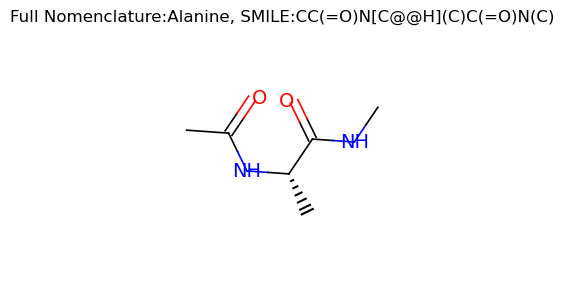

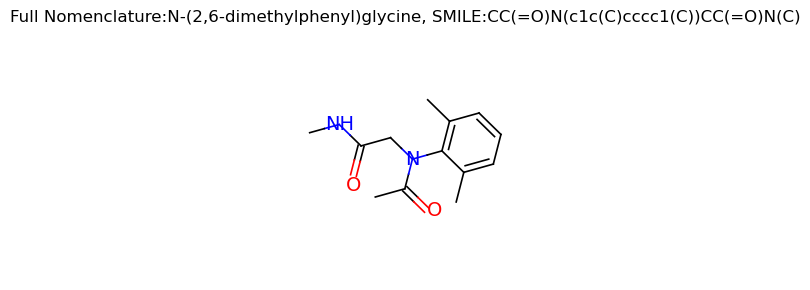

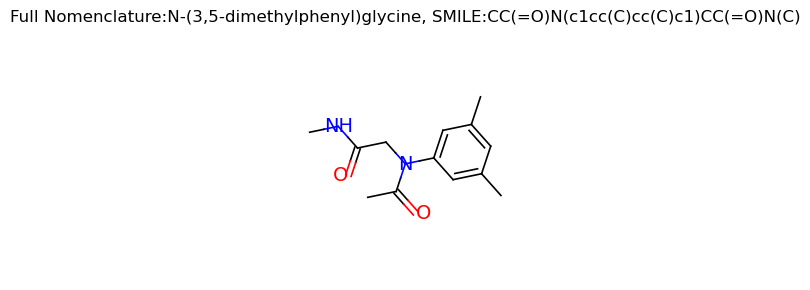

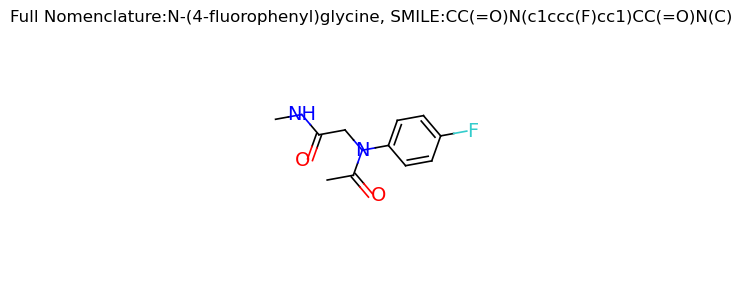

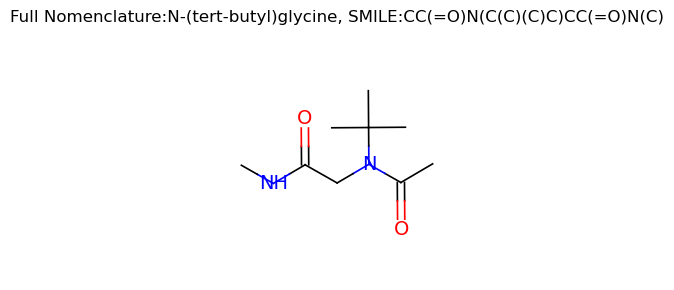

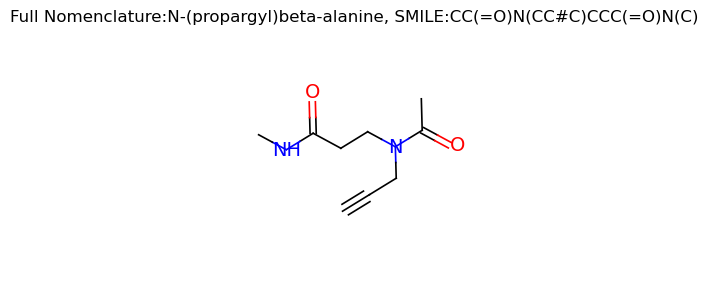

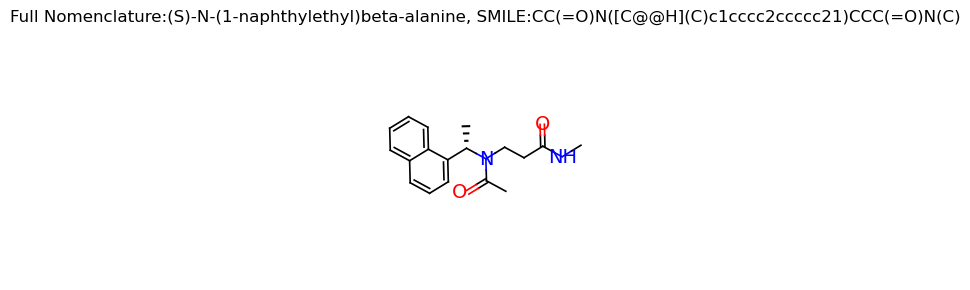

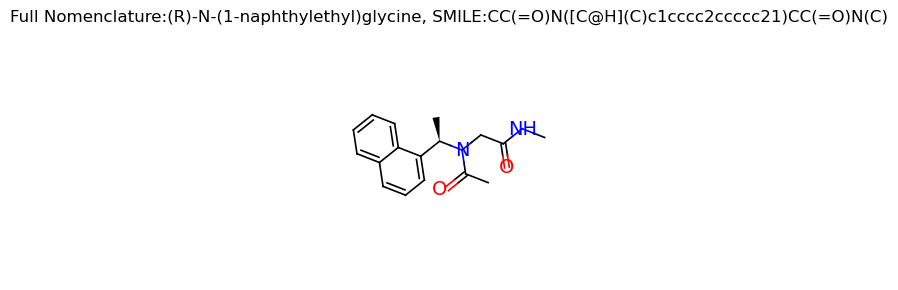

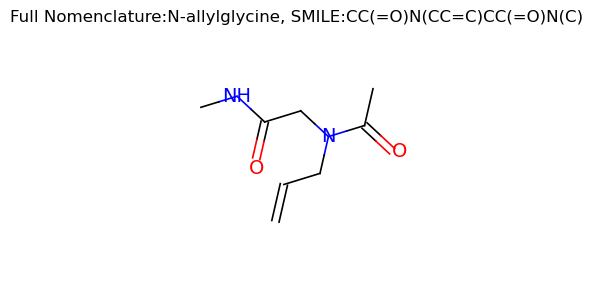

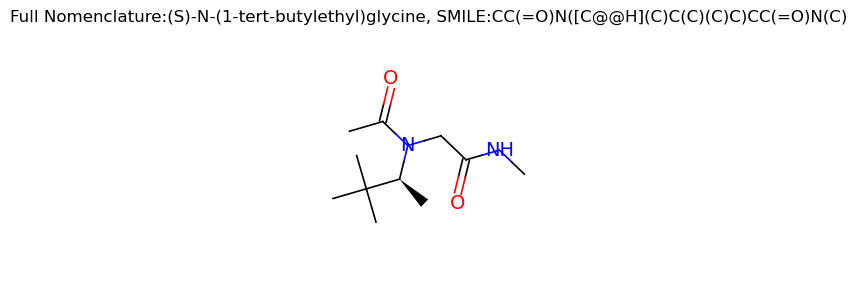

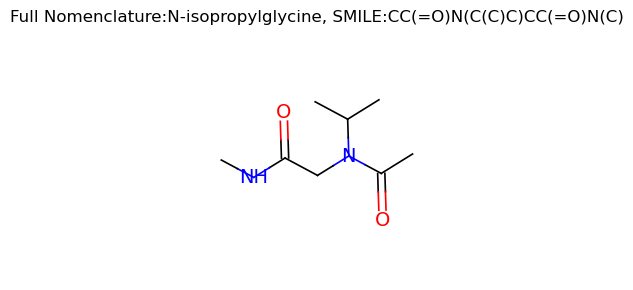

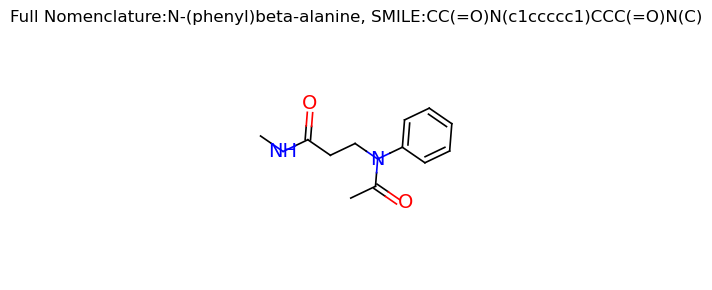

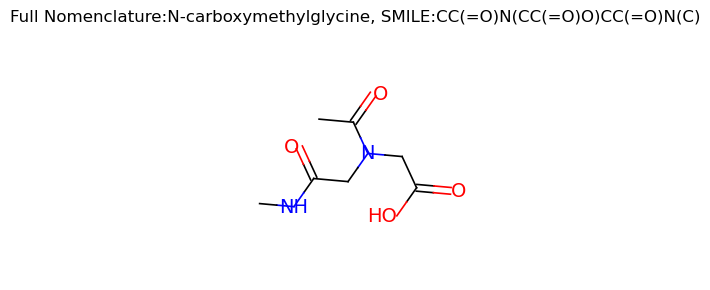

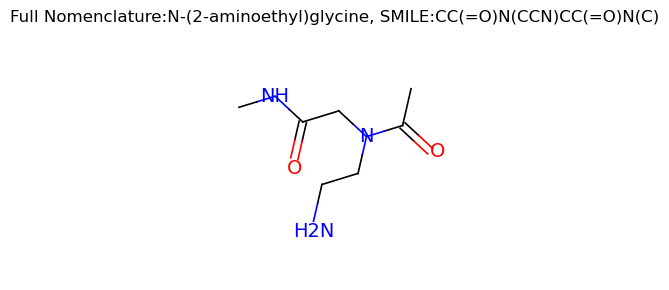

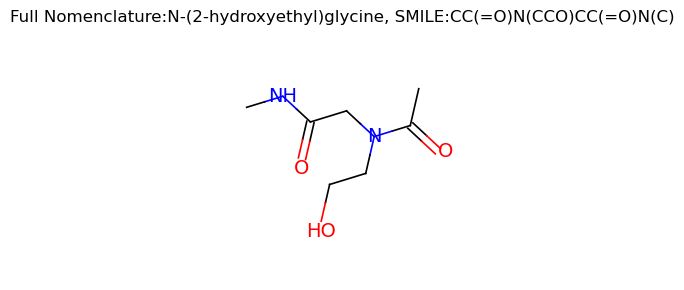

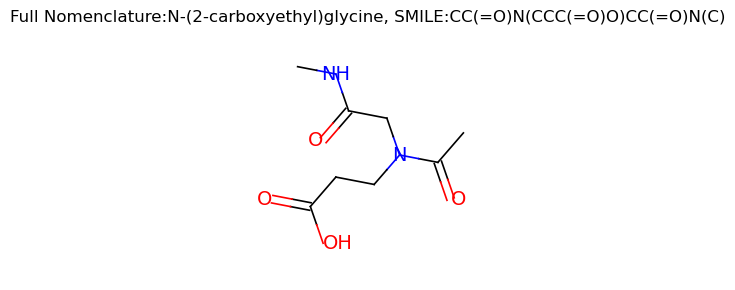

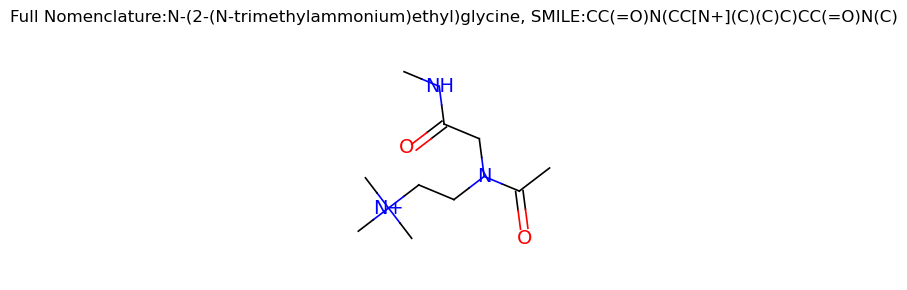

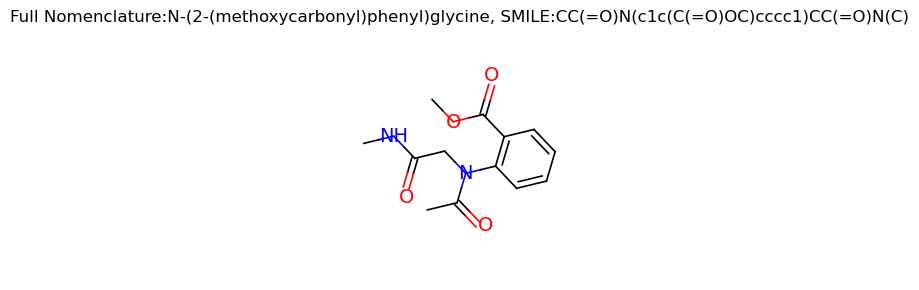

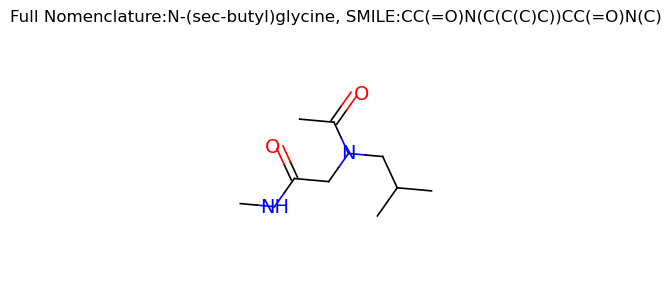

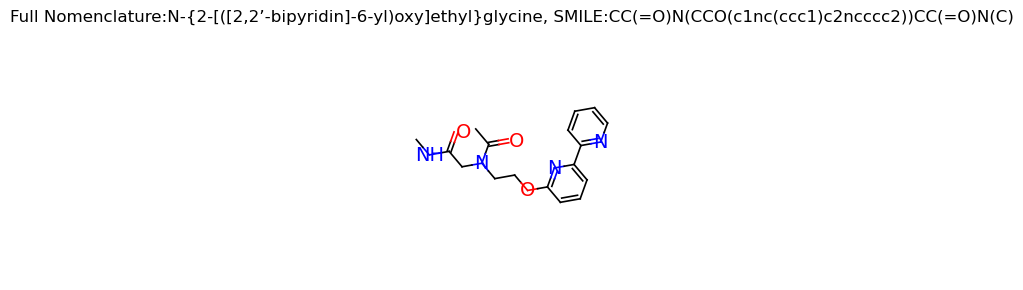

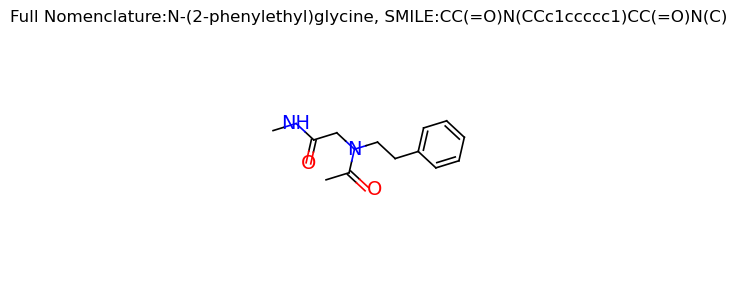

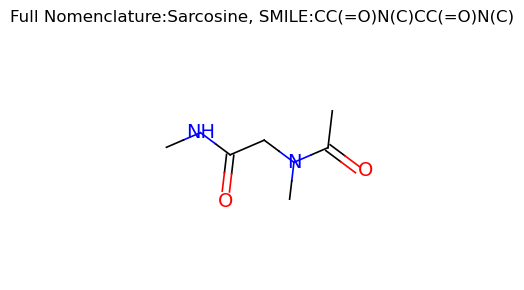

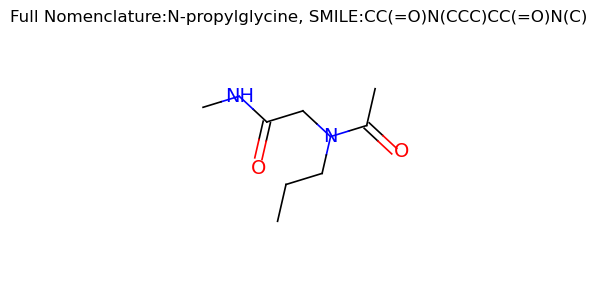

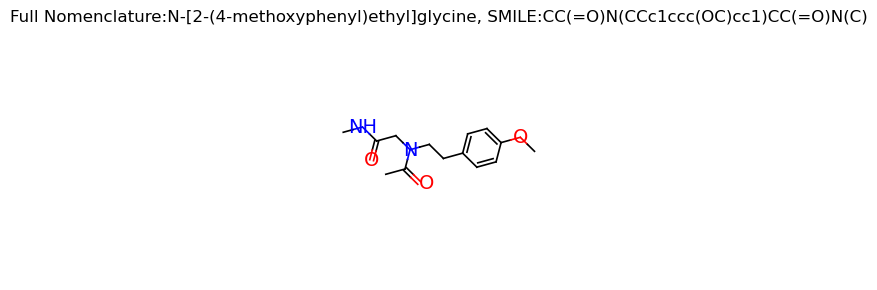

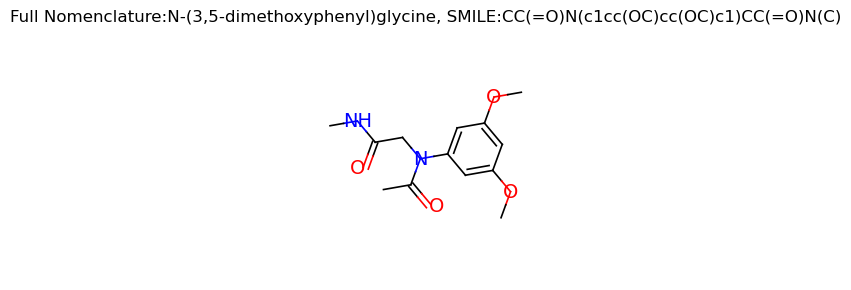

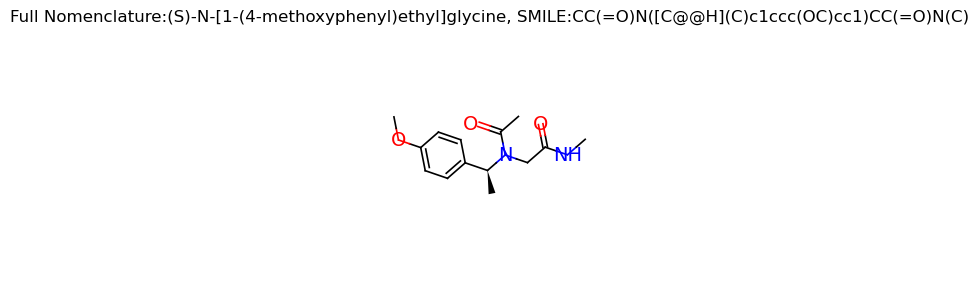

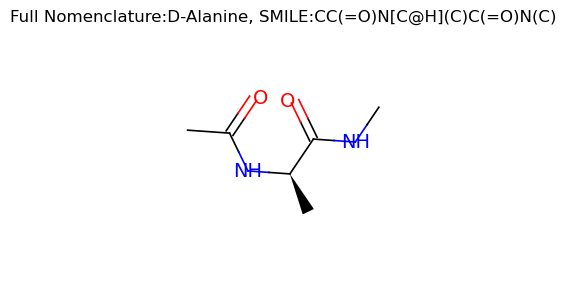

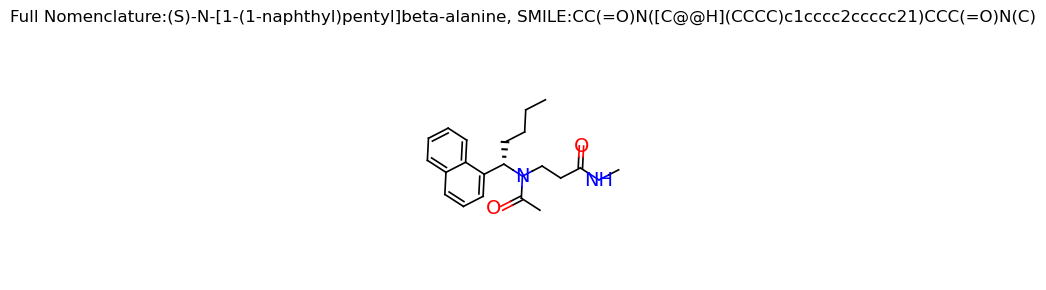

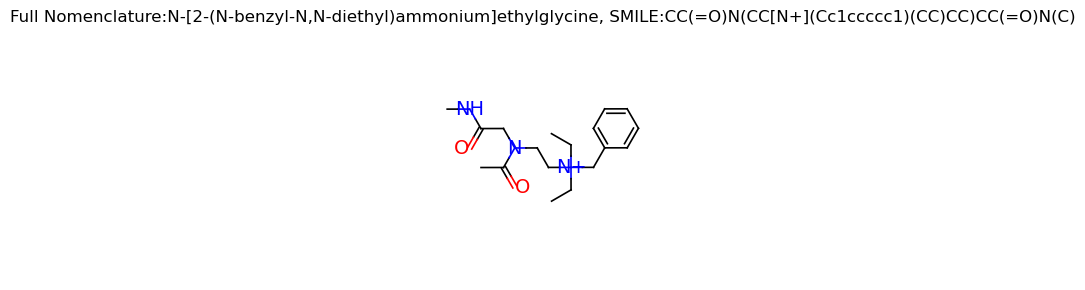

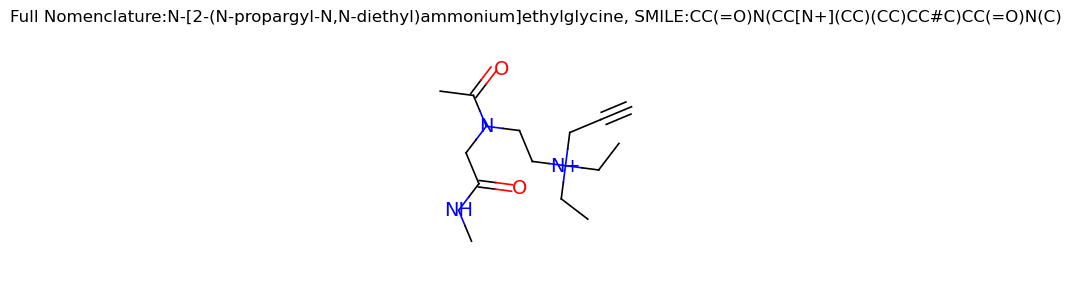

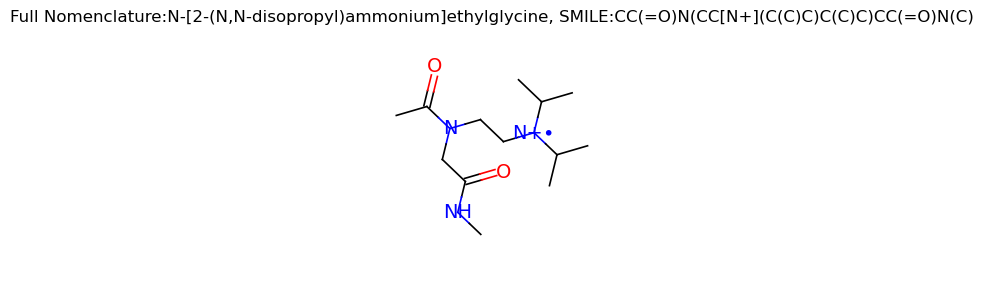

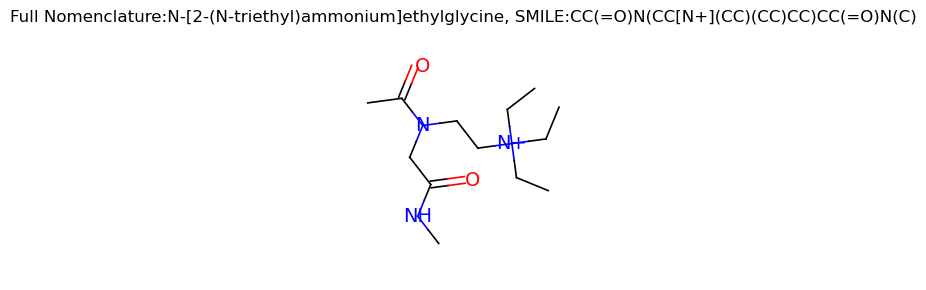

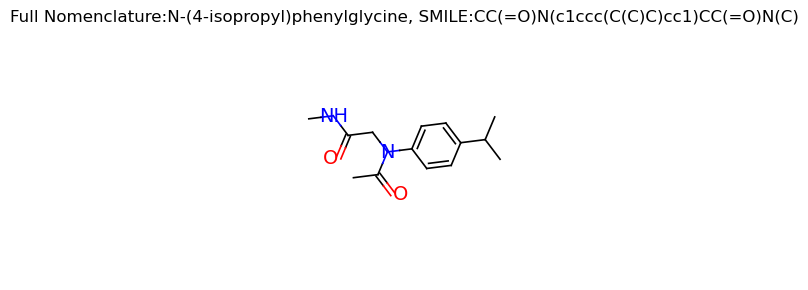

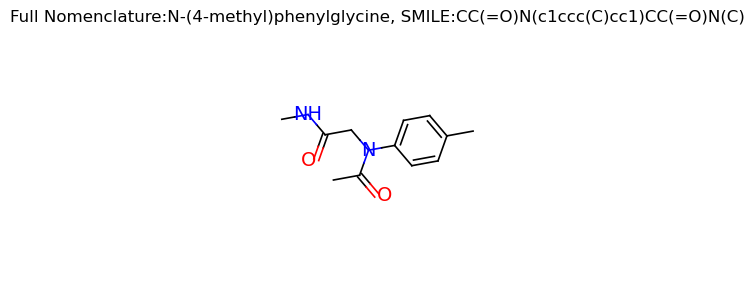

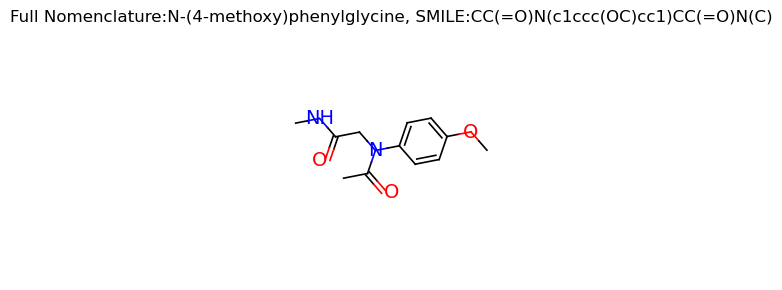

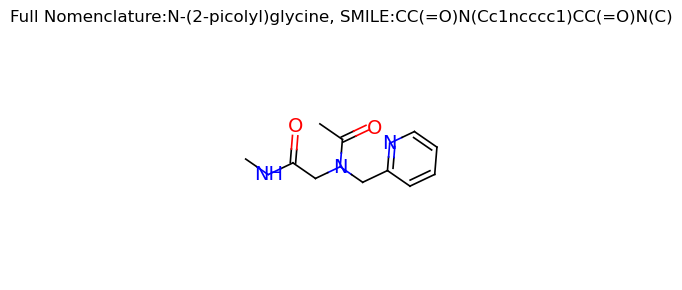

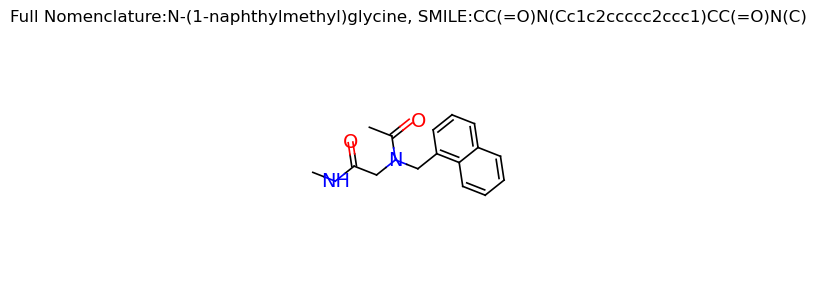

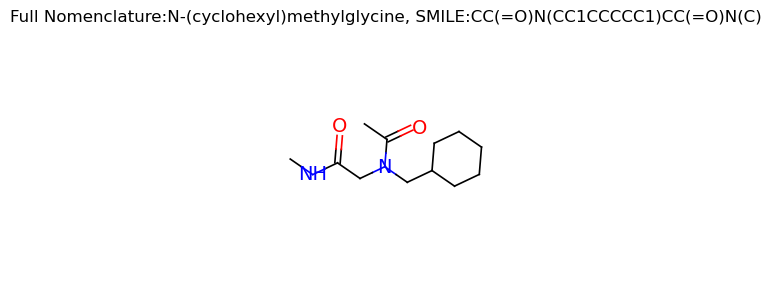

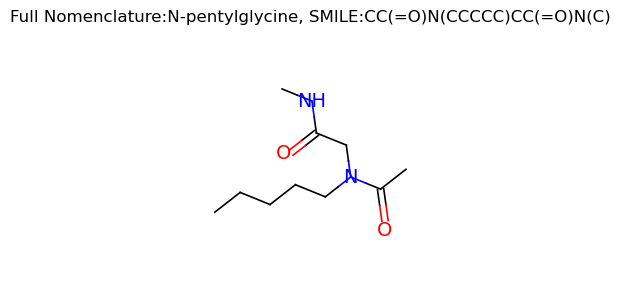

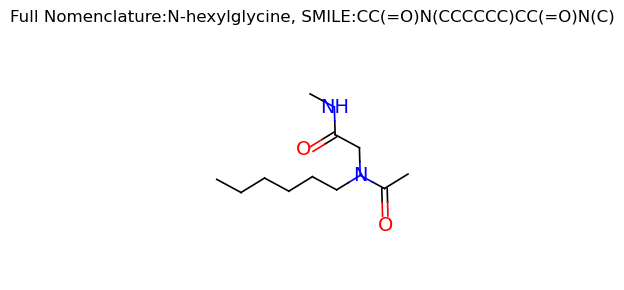

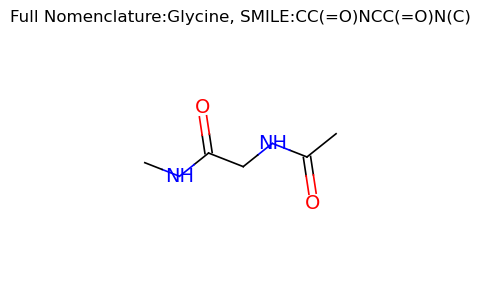

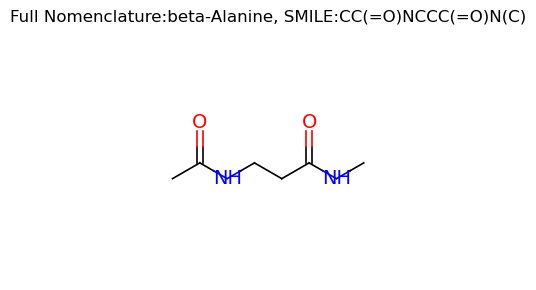

In [15]:
#construct the residues .mol2 file using 
#f"CC(=O){clean_smile}N(C)"
clean_res_dic = {}

for i, r in df_res.iterrows():
    try:
        #capped the SMILES in df_res 
        smile = r['SMILES'].replace('*', '')
        capped_smile = f"CC(=O){smile}N(C)"
        name = r['full_nomenclature']
        
        #constrcut image using rdkit 
        molecule = Chem.MolFromSmiles(capped_smile)
        fig = Draw.MolToMPL(molecule, size=(100,100))
        plt.title

        plt.title(f"Full Nomenclature:{name}, SMILE:{capped_smile}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Skipping row {i} due to error: {e}")


#smile = 'CC(=O)N([C@@H](C)c1ccccc1)CC(=O)N(C)'
#zw_l_alanine = Molecule.from_smiles(smile)

## Gnerate initial csv for adding shortname

In [7]:
# Use to make sure no repreated code presented 
def check_repeated(df, column):
    # Check for repeated codes
    duplicates = df[df.duplicated([column], keep=False)]

    if not duplicates.empty:
        print(f"There are repeated entries in the column '{column}':")
        print(duplicates)
    else:
        print(f"There are no repeated entries in the column '{column}'.")

#small function to code and decode using the df_codes 
def short_name_to_full_name(short_name):
    lookup_table = df_codes.set_index('short_name')['full_nomenclature'].to_dict()
    return lookup_table.get(short_name, "short_name not found")

def full_name_to_short_name(full_name):
    lookup_table = df_codes.set_index('full_nomenclature')['short_name'].to_dict()
    return lookup_table.get(full_name, "full_nomenclature not found")

In [8]:
# selected the desired column as new df 
df_codes_unedited = df_res[['full_nomenclature', 'SMILES', 'short_name']]

print(df_codes_unedited)
df_codes_unedited.to_csv('data/codes_unedited.csv', index=False)

                   full_nomenclature                        SMILES short_name
0   (S)-N-(1-cyclohexylethyl)glycine  *N([C@@H](C)C1CCCCC1)CC(=O)*       Nsch
1   (R)-N-(1-cyclohexylethyl)glycine   *N([C@H](C)C1CCCCC1)CC(=O)*       Nrch
2             (S)-N-(2-butyl)glycine        *N([C@@H](C)CC)CC(=O)*       Nssb
3             (R)-N-(2-butyl)glycine         *N([C@H](C)CC)CC(=O)*       Nrsb
4       (S)-N-(1-phenylethyl)glycine  *N([C@@H](C)c1ccccc1)CC(=O)*       Nspe
..                               ...                           ...        ...
61       N-(cyclohexyl)methylglycine          *N(CC1CCCCC1)CC(=O)*        Ncy
62                   N-pentylglycine              *N(CCCCC)CC(=O)*        NaN
63                    N-hexylglycine             *N(CCCCCC)CC(=O)*        NaN
64                           Glycine                     *NCC(=O)*        Gly
65                      beta-Alanine                    *NCCC(=O)*    betaAla

[66 rows x 3 columns]


In [8]:
#Check the uniqueness of the short_name
df_codes = pd.read_csv('data/codes.csv')

print(check_repeated(df_codes, 'short_name'))

There are no repeated entries in the column 'short_name'.
None


In [35]:
# search the short_name and full_name
short_name_to_full_name('BNP')
full_name_to_short_name('N-(propargyl)beta-alanine')

'BNP'

## Construct a residues/ with all the resideus being constructed from SMILES into .mol2 file, assigned unique code as name

### run the following code in ChimeraX python shell

In [4]:
from chimerax.core.session import Session
from chimerax.core.commands import run
import csv
import os

os.chdir('/Users/starwingchen/Voelz_Lab/git/peptoid_24summer')

with open('data/codes.csv', mode='r') as file:
    csv_reader = csv.DictReader(file)
    
    # Iterate over each row in the CSV
    for i, row in enumerate(csv_reader):
        smile = row['SMILES']
        clean_smile = smile.replace('*','')
        capped_smile = f"CC(=O){clean_smile}N(C)C"
        short_name = row['short_name']

        #create path 
        mol2_path = f"residues/GAFF/unmodified/{short_name}/"
        os.makedirs(os.path.dirname(mol2_path), exist_ok=True)
        
        #run command
        try:
            run(session, f"open smiles:{capped_smile} resName {short_name}")
            #print(f"open smiles:{smiles} resName {code}")
            run(session, f"save {mol2_path}{short_name}.mol2 format mol2")
            #print(f"save residues/{code}.mol2 format mol2")
            run(session, "close all")
        except Exception as e:
            print(f"Error processing {capped_smile}: {e}")

ModuleNotFoundError: No module named 'chimerax'

## Constructing the file for peptoid

In [13]:
# Create a df with all the solution NMR as a column with the short_name of the residues 
os.chdir('/Users/starwingchen/Voelz_Lab/git/peptoid_24summer/')

short_names = {}

for col in df_seq.columns:
    column = df_seq[col]
    short_names[col] = []  # Initialize an empty list for each column
    for i, r in column.items():
        if r is not None:
            full_name = r
            short_name = full_name_to_short_name(full_name)
            if short_name != 'full_nomenclature not found':
                short_names[col].append(short_name)

df_short_names = pd.DataFrame.from_dict(short_names, orient='index').transpose()

print(df_short_names)

df_short_names.to_csv('data/short_names.csv', index=False)

  06AA1-9-A 13AC1-6-A 17AB1-5-A 17AB2-8-A 18AC2-7-A 18AC1-3-A 19AE1-4-A  \
0       NSP       NYZ       NNE       NXY       NCE       NCM       NAE   
1       NSP       NNE       NYZ       NRN       NAE       NPM       NPE   
2       NSP       NXY       NRN       NXF       NHO       ALA       NAE   
3       NSP       NNE       NPH       NNE       NSP      None       NPE   
4       NSP       NXF      None       NYZ       NCM      None      None   
5       NSP       NNE      None       NRN       NPM      None      None   
6       NSP      None      None       NPH       ALA      None      None   
7       NSP      None      None      None      None      None      None   
8       NSP      None      None      None      None      None      None   
9      None      None      None      None      None      None      None   

  19AF1-10-A  
0        NYZ  
1        NIX  
2        NIS  
3        NXB  
4        NDM  
5        NXA  
6        NTM  
7        NMA  
8        NMO  
9        NIX  


In [14]:
# output only the kind of res
unique_short_names={}

for col in df_short_names.columns:
    column = df_short_names[col]
    unique_short_names[col] = []
    encountered = set()
    for i, r in column.items():
        if r not in encountered:
            unique_short_names[col].append(r)
            encountered.add(r)

df_unique_short_names = pd.DataFrame.from_dict(unique_short_names, orient='index').transpose()

print(df_unique_short_names)

  06AA1-9-A 13AC1-6-A 17AB1-5-A 17AB2-8-A 18AC2-7-A 18AC1-3-A 19AE1-4-A  \
0       NSP       NYZ       NNE       NXY       NCE       NCM       NAE   
1      None       NNE       NYZ       NRN       NAE       NPM       NPE   
2      None       NXY       NRN       NXF       NHO       ALA      None   
3      None       NXF       NPH       NNE       NSP      None      None   
4      None      None      None       NYZ       NCM      None      None   
5      None      None      None       NPH       NPM      None      None   
6      None      None      None      None       ALA      None      None   
7      None      None      None      None      None      None      None   
8      None      None      None      None      None      None      None   

  19AF1-10-A  
0        NYZ  
1        NIX  
2        NIS  
3        NXB  
4        NDM  
5        NXA  
6        NTM  
7        NMA  
8        NMO  


In [15]:
import pandas as pd
import subprocess
import os

# Set the working directory
os.chdir('/Users/starwingchen/Voelz_Lab/git/peptoid_24summer/')

# Load the DataFrame from the CSV file
short_name_csv = 'data/short_names.csv'
df_short_name = pd.read_csv(short_name_csv)
print("DataFrame loaded successfully")
print(df_short_name.head())  # Print the first few rows to verify

# Change to the specified directory
os.chdir('/Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/')
print("Changed directory to /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/")

# Initialize an empty set to keep track of encountered short names
encountered = set()

# Iterate over the rows of the DataFrame
for i, r in df_short_name.iterrows():
    # Iterate over the short names in each row
    for short_name in r:
        if short_name not in encountered:
            if short_name is not None:
                encountered.add(short_name)
                command = f"cp -r unmodified/{short_name} modified/{short_name}"
                print(f"Executing command: {command}")
                # Execute the command
                try:
                    subprocess.run(command, shell=True, check=True)
                except subprocess.CalledProcessError as e:
                    print(f"Failed to execute command: {command}")
                    print(e)
                

DataFrame loaded successfully
  06AA1-9-A 13AC1-6-A 17AB1-5-A 17AB2-8-A 18AC2-7-A 18AC1-3-A 19AE1-4-A  \
0       NSP       NYZ       NNE       NXY       NCE       NCM       NAE   
1       NSP       NNE       NYZ       NRN       NAE       NPM       NPE   
2       NSP       NXY       NRN       NXF       NHO       ALA       NAE   
3       NSP       NNE       NPH       NNE       NSP       NaN       NPE   
4       NSP       NXF       NaN       NYZ       NCM       NaN       NaN   

  19AF1-10-A  
0        NYZ  
1        NIX  
2        NIS  
3        NXB  
4        NDM  
Changed directory to /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/
Executing command: cp -r unmodified/NSP modified/NSP
Executing command: cp -r unmodified/NYZ modified/NYZ
Executing command: cp -r unmodified/NNE modified/NNE
Executing command: cp -r unmodified/NXY modified/NXY
Executing command: cp -r unmodified/NCE modified/NCE
Executing command: cp -r unmodified/NCM modified/NCM
Executing command: cp -r

cp: unmodified/nan: No such file or directory


In [8]:
short_name = 'NSP'
command = f"python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -s N -t C {short_name}.mol2 {short_name} CappingAtoms.dat X G 0"
print(command)
command = f"python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -t C {short_name}.mol2 N{short_name} CappingAtoms.dat N G 0"
print(command)
command = f"python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -s N {short_name}.mol2 C{short_name} CappingAtoms.dat C G 0"
print(command)

python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -s N -t C NSP.mol2 NSP CappingAtoms.dat X G 0
python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -t C NSP.mol2 NNSP CappingAtoms.dat N G 0
python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -s N NSP.mol2 CNSP CappingAtoms.dat C G 0


In [ ]:
python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -t C NSP.mol2 NNSP CappingAtoms.dat N G 0
python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -s N NSP.mol2 CNSP CappingAtoms.dat N G 0
cp -r unmodified/NNSP modified/NNSP

acpype -p '06AA1-9-A.prmtop' -x '06AA1-9-A.crd'

/Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/C_terminal/modified/CNSP

source oldff/leaprc.ff14SB
source leaprc.gaff
loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/modified/NSP/NSP.off
loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/N_terminal/modified/NNSP/NNSP.off
protein = sequence { NNSP NSP NSP NSP NSP NSP NSP NSP NSP NHE }
savepdb protein 06AA1-9-A.pdb
saveAmberParm protein 06AA1-9-A.prmtop 06AA1-9-A.crd
quit


Command
```
short_name = code 

command = python ~/Voelz_Lab/git/prep-tools/scripts/build_amber_residue.py -s N {short_name}.mol2 C{short_name} CappingAtoms.dat C G 0

```
tleap -f 19AE1-4-A.leap
acpype -p '19AE1-4-A.prmtop' -x '19AE1-4-A.crd'

source oldff/leaprc.ff14SB
source leaprc.gaff

loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/modified/NNE/NNE.off
loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/modified/NXY/NXY.off
loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/modified/NXF/NXF.off

loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/N_terminal/modified/NNYZ/NNYZ.off
loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/C_terminal/modified/CNNE/CNNE.off

protein = sequence { NNYZ NNE NXY NNE NXF CNNE }
savepdb protein 13AC1-6-A.pdb
saveAmberParm protein 13AC1-6-A.prmtop 13AC1-6-A.crd
quit

In [ ]:
tleap -f 17AB1-5-A.leap
acpype -p '17AB1-5-A.prmtop' -x '17AB1-5-A.crd'

source oldff/leaprc.ff14SB
source leaprc.gaff

loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/modified/NNE/NNE.off
loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/modified/NYZ/NYZ.off
loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/modified/NRN/NRN.off
loadoff /Users/starwingchen/Voelz_Lab/git/peptoid_24summer/residues/GAFF/middle/modified/NPH/NPH.off

protein = sequence { ACE NNE NYZ NRN NPH NHE }
savepdb protein 17AB1-5-A-A.pdb
saveAmberParm protein 17AB1-5-A.prmtop 17AB1-5-A.crd
quit


open smiles:NC(=O)CNS(=O)(=O)Cc1ccccc1 resName NTS
